In [3]:
#I was asked whether we shoul buy the NIO stock or not. Therefore, I tried to come up a solution.
#In this project, we extract the stock price of NIO and predict the price
#for the next couple of days. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from pandas_datareader.data import DataReader
from datetime import datetime

In [4]:
Company_name = 'NIO'#Change this if you are intrested in other companies
RightNow = datetime.now()
StartingPoint = datetime(RightNow.year - 5, RightNow.month, RightNow.day)# we use the data of one year ago up to now. You play with the start point to see the impact on the prediction
stock = DataReader(Company_name, 'yahoo', StartingPoint, RightNow)
stock.tail() #Uncomment this to see the last five datapoint of the stock price
#stock.describe()# some statistics about NIO data


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,54.450001,50.669998,51.200001,53.490002,213109700,53.490002
2021-01-05,53.750000,50.400002,51.970001,53.200001,147474800,53.200001
2021-01-06,55.279999,49.080002,54.020000,50.500000,176397700,50.500000
2021-01-07,54.610001,52.349998,53.049999,54.279999,119429200,54.279999
2021-01-08,59.310001,55.880001,57.759998,58.919998,217792300,58.919998


Last code block extracts the data for a year. If you want to work with one-month data instead, you can uncomment the next block.

In [5]:

#Today = datetime.now()
#if Today.month == 1:
#    one_month_ago = Today.replace(year=Today.year - 1, month=12)
#else:
#  extra_days = 0
#  while True:
#    try:
#      one_month_ago = Today.replace(month=Today.month - 1, day=Today.day - extra_days)
#      break
#    except ValueError:
#      extra_days += 1
#StartingPoint = datetime(one_month_ago.year , one_month_ago.month, one_month_ago.day)
#stock = DataReader(Company_name, 'yahoo', StartingPoint, RightNow)

Next, we calculate the moving average and daily return. The window size is 10days. But feel free to change it.

In [6]:
Window_Size = 10
stock['MovingAVG'] = stock['Adj Close'].rolling(Window_Size).mean()
stock['DailyRetrun'] = stock['Adj Close'].pct_change()

Let's plot the adjusted closing price, trading volume, and moving average as a function of date.


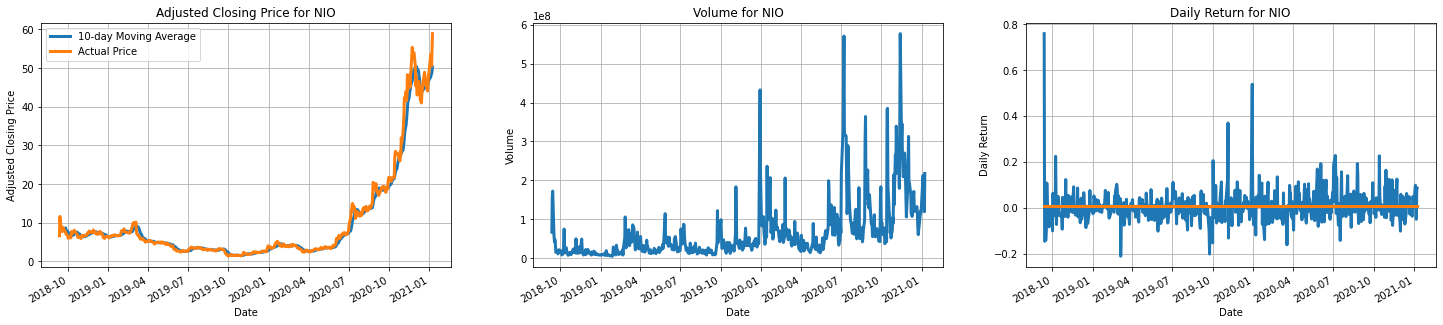

In [7]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
stock['MovingAVG'].plot(linewidth=3,label =  str(Window_Size)+'-day Moving Average')
stock['Adj Close'].plot(linewidth=3, label = 'Actual Price')
plt.legend()
plt.title('Adjusted Closing Price for '+Company_name)
plt.ylabel('Adjusted Closing Price')
plt.grid()
plt.subplot(1, 3, 2)
stock['Volume'].plot(linewidth=3)
plt.title('Volume for '+Company_name)
plt.ylabel('Volume')
plt.grid()
plt.subplot(1, 3, 3)
stock['DailyRetrun'].plot(linewidth=3)
(stock['DailyRetrun'].mean() +stock['DailyRetrun']* 0).plot(linewidth=3)
plt.title('Daily Return for '+Company_name)
plt.ylabel('Daily Return')
plt.grid()

On Average, NIO stock changes 0.0060440978811867095(+/- 0.0715602606249432) percent daily. Positive (resp. negative) percentage means increase (resp. decrease)


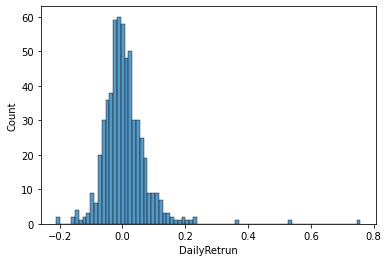

In [8]:
print('On Average, {} stock changes {}(+/- {}) percent daily. Positive (resp. negative) percentage means increase (resp. decrease)'.format(Company_name, stock['DailyRetrun'].mean(),stock['DailyRetrun'].std()))
#Standard Deviation is quite High :((((
sea.histplot(stock['DailyRetrun'][1:], bins=80)#Histogram for a better visualization

In [9]:
#normalize the data between zero and one
from sklearn.preprocessing import MinMaxScaler
transformation = MinMaxScaler(feature_range=(0,1))
scaled_data = transformation.fit_transform(np.array(stock['Close']).reshape(-1,1))
#devide data into training and test
Dataset_Size = len(scaled_data)
training_Size = int(Dataset_Size * 0.85)
test_Size = Dataset_Size - training_Size
train_data = scaled_data[0:training_Size, 0]
#Windowing. Window size is 50
w = 100
x_train = np.array([train_data[i-w:i] for i in range(w, (training_Size))])
y_train = np.array([train_data[i] for i in range(w, (training_Size))])
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
### Test Data
test_data = scaled_data[training_Size-w:, 0]
test_Size = Dataset_Size - training_Size 
x_test = np.array([test_data[i-w:i] for i in range(w, (test_Size+w))])
y_test = np.array([test_data[i] for i in range(w, (test_Size+w))])

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

print(y_test.shape)
print(x_test.shape)

(88,)
(88, 100, 1)


In [46]:
import tensorflow as tf
class myCall(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, log):
    if log['loss']<5*10**(-4):
      print('Stop Training')
      self.model.stop_training = True
mycall = myCall()
mycall = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
#Build the LSTM model
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(25,activation='tanh'),
        tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=15,callbacks = [mycall],validation_split=0.1 )

Epoch 1/15
358/358 [==============================] - 21s 52ms/step - loss: 4.8258e-04 - val_loss: 0.0035
Epoch 2/15
358/358 [==============================] - 18s 51ms/step - loss: 3.1421e-04 - val_loss: 0.0086
Epoch 3/15
358/358 [==============================] - 18s 51ms/step - loss: 2.2721e-04 - val_loss: 5.5652e-04
Epoch 4/15
358/358 [==============================] - 18s 51ms/step - loss: 1.4724e-04 - val_loss: 3.9039e-04
Epoch 5/15
358/358 [==============================] - 18s 50ms/step - loss: 9.5947e-05 - val_loss: 5.1724e-04
Epoch 00005: early stopping


In [47]:
# Get the models predicted price values 
model.summary()
model.evaluate(x_test,y_test)
predictions = transformation.inverse_transform(model.predict(x_test))#denormalize
len(predictions)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100, 128)          66560     
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_13 (Dense)             (None, 25)                1625      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________
3/3 [==============================] - 1s 43ms/step - loss: 0.0033


88

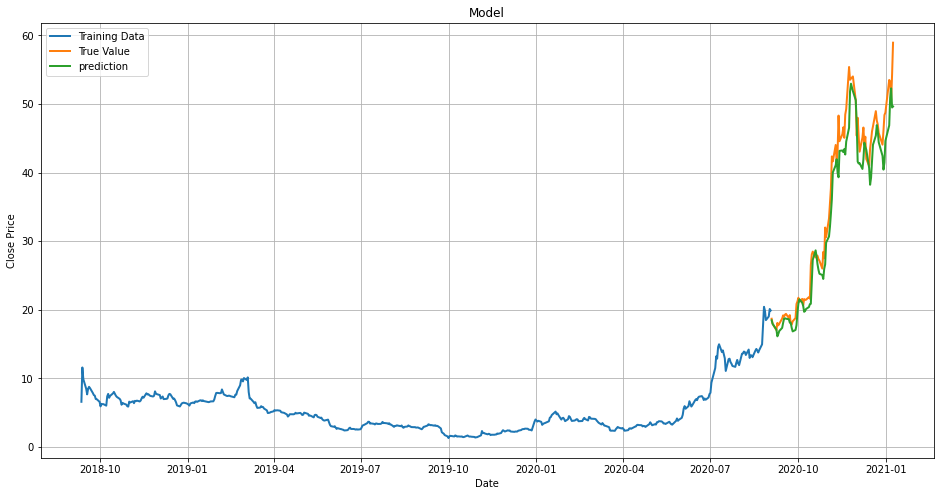

In [56]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(stock.index[:training_Size],stock['Close'][:training_Size],label='Training Data',linewidth=2)
plt.plot(stock.index[training_Size:],stock['Close'][training_Size:],label='True Value ',linewidth=2)
plt.plot(stock.index[training_Size:], predictions,label = 'prediction',linewidth=2)
plt.legend(loc='upper left')
plt.grid()
plt.show()